In [1]:
# local version, copied from Eagle
# JLCY 2021-02-12

# based on: 
# /a2e-mmc/assessment/blob/master/examples/UsingTSLISToutput.ipynb

# developed on Mac WE42120

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram

data_dir = '/Users/leec813/Documents/mmc/sgp/data/'
obs_dir = data_dir+'obs/'
era_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/era5/'
gfs_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/gfs/'

# time step of wrf runs:
erad01_wrf_dt = 6
erad02_wrf_dt = 2
gfs_wrf_dt = 9

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(data_dir+'data-dir-name.csv', index_col=0)

# obs
wp_winds_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
# wp_vstat_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

wp_winds = xr.open_mfdataset(wp_winds_ncs)
# wp_vstat = xr.open_mfdataset(wp_vstat_ncs)

# According to Rob Newsom, lidar data taken < 100 m need to be thrown out. 
toss_wp_data_below_height = 100

In [3]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):
    
    # select data at few heights above threshold height
    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height))
                           .values[0:10])
    
    return [x for x in wp_height_list if str(x) != 'nan']

def plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_title): 

        lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
        lw = 1
        
        # reverse height list, useful for plotting
        wp_height_list = get_wp_height_list(wp_ds)[:len(lc_list)][::-1]

        for hgt, lc in enumerate(lc_list): 

            # slice of data at each height
            wrf_slice = wrf_ds.sel(height=wp_height_list[hgt])
            wp_slice = wp_ds.sel(height=wp_height_list[hgt])

            plt.plot(wrf_slice['datetime'], wrf_slice[wrf_var], 
                     label=str(np.round(wrf_slice['height'].values).astype(int))+' m', 
                     c=lc, linewidth=lw)
            plt.plot(wp_slice['time'], wp_slice[wp_var], c=lc, linewidth=lw, linestyle='--')

        plt.xticks(rotation='vertical')
        # 24 hours of data in plot
        plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
        plt.ylabel(var_title)
        
        plt.title(wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)
        plt.legend(title=wrf_run)
        
        plt.show()

def read_plot_obs_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    era_wrf_dir = era_wrf_all_dir+date_col['era']+'/'

    erad01_file_name = 'c1.d01'
    erad01_file_path = era_wrf_dir+erad01_file_name
    erad01_tower = Tower(erad01_file_path)

    erad02_file_name = 'c1.d02'
    erad02_file_path = era_wrf_dir+erad02_file_name
    erad02_tower = Tower(erad02_file_path)

    gfs_wrf_dir = gfs_wrf_all_dir+date_col['gfs']+'/'
    
    gfs_file_name = 'SGP.d01'
    gfs_file_path = '{}{}'.format(gfs_wrf_dir, gfs_file_name)
    gfs_tower = Tower(gfs_file_path)

    # simulation start time:
    # era & gfs runs have the same start times
    wrf_start = date_col['wrf_start']

    tower_list = [erad01_tower, erad02_tower, gfs_tower]
    dt_list = [erad01_wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    erad01_ds = read_tower_to_ds(erad01_tower, wrf_start, erad01_wrf_dt, wrf_height_list)
    erad02_ds = read_tower_to_ds(erad02_tower, wrf_start, erad02_wrf_dt, wrf_height_list)
    gfs_ds = read_tower_to_ds(gfs_tower, wrf_start, gfs_wrf_dt, wrf_height_list)
    
    wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}
    
    # for lidar only...
    var_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
    
    for wrf_var, var in var_dict.items():
        for wrf_run, wrf_ds in wrf_dict.items(): 
            plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1])
            
    return obs_ds, erad01_ds, erad02_ds, gfs_ds

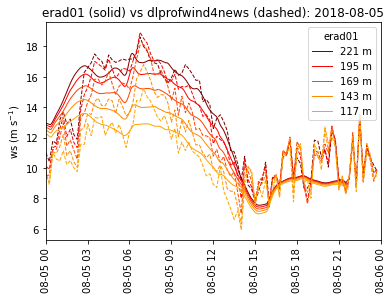

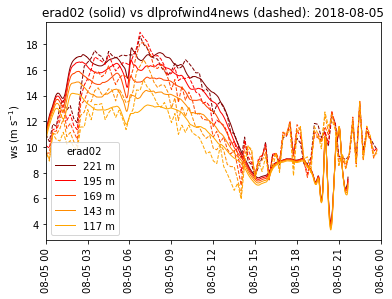

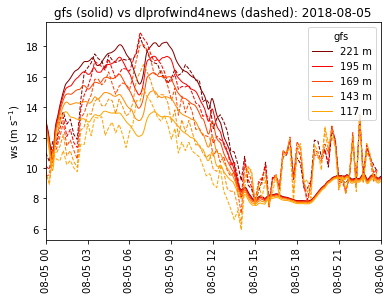

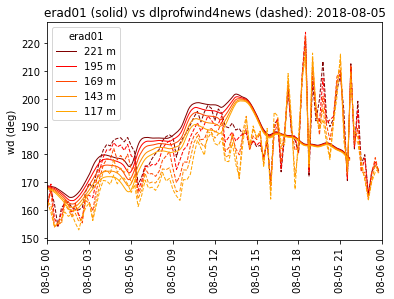

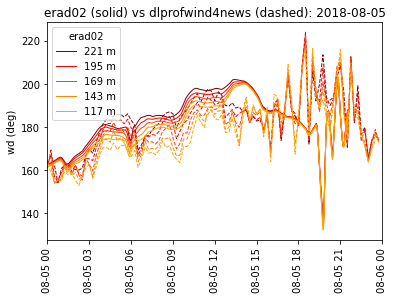

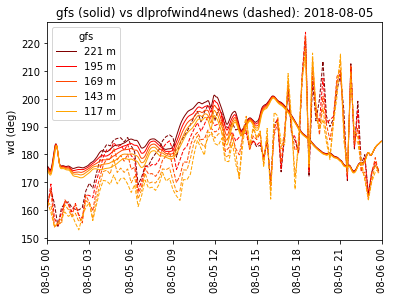

(<xarray.Dataset>
 Dimensions:               (bound: 2, height: 164, time: 96)
 Coordinates:
   * time                  (time) datetime64[ns] 2018-08-05T00:00:45.841247 .....
   * height                (height) float32 90.93 116.9 ... 4.3e+03 4.326e+03
 Dimensions without coordinates: bound
 Data variables:
     base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
     time_offset           (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
     time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
     scan_duration         (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
     elevation_angle       (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
     nbeams                (time) int16 dask.array<chunksize=(96,), meta=np.ndarray>
     u                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
     u_error               (time, height) float32 dask.array<

In [9]:
read_plot_obs_wrf_1day(wp_winds, '2018-08-05')

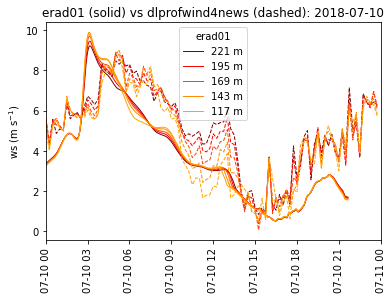

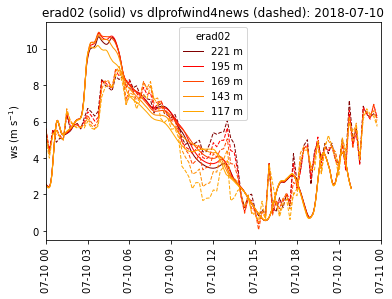

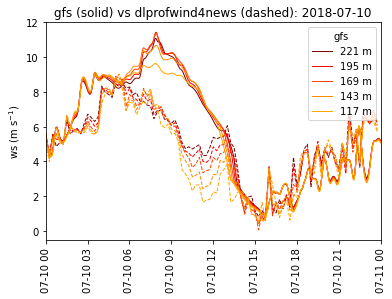

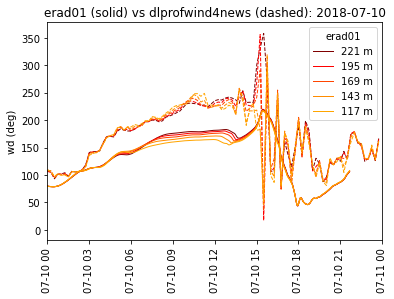

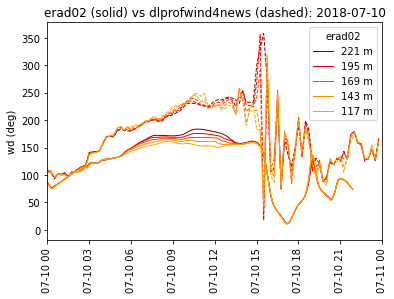

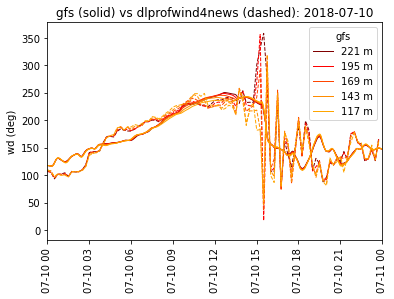

In [4]:
read_plot_obs_wrf_1day(wp_winds, '2018-07-10')

In [37]:
# obs_ds, erad01_ds, erad02_ds, gfs_ds = read_plot_obs_wrf_1day(wp_winds, '2018-08-05')

eval_date = '2018-08-05'
obs = wp_winds

date_col = data_dir_df[eval_date]

# start date & end date are the same because only looking at 24 hours of data
obs_ds = obs.sel(time=slice(eval_date, eval_date))

# for lidar...
obs_height_list = get_wp_height_list(obs_ds)

# select more model heights than obs
wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
wrf_height_list.sort()

era_wrf_dir = era_wrf_all_dir+date_col['era']+'/'

erad01_file_name = 'c1.d01'
erad01_file_path = era_wrf_dir+erad01_file_name
erad01_tower = Tower(erad01_file_path)

erad02_file_name = 'c1.d02'
erad02_file_path = era_wrf_dir+erad02_file_name
erad02_tower = Tower(erad02_file_path)

gfs_wrf_dir = gfs_wrf_all_dir+date_col['gfs']+'/'

gfs_file_name = 'SGP.d01'
gfs_file_path = '{}{}'.format(gfs_wrf_dir, gfs_file_name)
gfs_tower = Tower(gfs_file_path)

# simulation start time:
# era & gfs runs have the same start times
wrf_start = date_col['wrf_start']

tower_list = [erad01_tower, erad02_tower, gfs_tower]
dt_list = [erad01_wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

erad01_ds = read_tower_to_ds(erad01_tower, wrf_start, erad01_wrf_dt, wrf_height_list)
erad02_ds = read_tower_to_ds(erad02_tower, wrf_start, erad02_wrf_dt, wrf_height_list)
gfs_ds = read_tower_to_ds(gfs_tower, wrf_start, gfs_wrf_dt, wrf_height_list)

wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}

# for lidar only...
var_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}

time_start = np.max([erad01_ds['datetime'].min().values, erad01_ds['datetime'].min().values, 
                   gfs_ds['datetime'].min().values, obs_ds['time'].min().values])

time_end = np.min([erad01_ds['datetime'].max().values, erad01_ds['datetime'].max().values, 
                   gfs_ds['datetime'].max().values, obs_ds['time'].max().values])

# erad01_slice = erad01_ds.sel(height=obs_height_list[0])
# obs_slice = obs_ds.sel(height=obs_height_list[0])

# obs_time_len = obs_ds.sel(time=slice(time_start, time_end))['time'].shape
# erad01_time_len = erad01_ds.sel(datetime=slice(time_start, time_end))['datetime'].shape
# erad02_time_len = erad02_ds.sel(datetime=slice(time_start, time_end))['datetime'].shape
# gfs_time_len = gfs_ds.sel(datetime=slice(time_start, time_end))['datetime'].shape

In [38]:
# start w/ obs
time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

# refer to the most infrequent data series
# need matching time dimension to calculate correlation, etc. 
for model in [erad01_ds, erad02_ds, gfs_ds]: 
    model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']
    print(model_time_freq.shape)
    if time_freq.shape > model_time_freq.shape: 
        time_freq = model_time_freq

obs_slice = obs_ds.sel(height=obs_height_list[0], time=time_freq, method='nearest')
erad01_slice = erad01_ds.sel(height=obs_height_list[0], datetime=time_freq, method='nearest')

(12993,)
(38978,)
(8661,)


In [47]:
np.squeeze(erad01_slice['ws']).shape

(87,)

In [48]:
np.squeeze(obs_slice['wind_speed']).shape

(87,)

In [49]:
np.corrcoef(np.squeeze(obs_slice['wind_speed']).values, np.squeeze(erad01_slice['ws']).values)[0,1]

0.6910928731157373

In [36]:
a

<xarray.Dataset>
Dimensions:   (station: 1, time: 87)
Coordinates:
    datetime  (time) datetime64[ns] 2018-08-05T00:00:48 ... 2018-08-05T21:30:30
    height    float64 116.9
  * station   (station) <U2 'c1'
  * time      (time) datetime64[ns] 2018-08-05T00:00:45.841247 ... 2018-08-05...
Data variables:
    u         (time, station) float64 -2.639 -2.68 -2.863 ... 0.02902 -0.1989
    w         (time, station) float64 -0.008511 -0.009822 ... 0.00425 0.001583
    pr        (time, station) float64 9.635e+04 9.636e+04 ... 9.656e+04
    v         (time, station) float64 11.98 11.78 11.84 ... 8.936 8.88 8.702
    theta     (time, station) float64 307.3 307.1 306.8 ... 310.0 310.1 310.3
    qv        (time, station) float64 0.01332 0.01333 ... 0.01188 0.01202
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (time, station) float64 305.2 304.8 304.4 ... 309.2 309.3 309.3
    q2        (time, station) float64 0.01392 0.01399 ... 0.01241 0.01255
    u10       (time, station) float64 -1.972 -2.007 -2.243 ... -0.08645 -0.2673
    v10       (time, station) float64 7.617 7.427 7.792 ... 6.974 6.885 6.719
    psfc      (time, station) float64 9.756e+04 9.757e+04 ... 9.776e+04
    lwd       (time, station) float64 418.8 417.7 416.1 ... 425.4 426.3 427.2
    swd       (time, station) float64 190.4 153.5 112.5 ... 623.6 597.6 565.7
    hfx       (time, station) float64 10.52 -3.777 -13.9 ... 238.4 222.5 203.0
    lfx       (time, station) float64 116.8 101.3 78.46 ... 225.1 219.4 212.1
    tsk       (time, station) float64 305.4 304.8 304.0 ... 312.9 312.8 312.6
    slttop    (time, station) float64 306.1 306.0 305.9 ... 306.9 307.1 307.3
    rainc     (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (time, station) float64 12.27 12.08 12.18 ... 8.937 8.88 8.704
    wd        (time, station) float64 167.6 167.2 166.4 ... 181.1 180.2 178.7

In [25]:
erad01_ds.sel(datetime=slice(time_start, time_end))['datetime'].shape > obs_ds.sel(time=slice(time_start, time_end))['time'].shape

True

In [6]:
time_start

numpy.datetime64('2018-08-05T00:00:45.841247000')

In [7]:
time_end

numpy.datetime64('2018-08-05T21:40:00.000000000')

In [16]:
erad01_ds = erad01_ds.sel(height=obs_height_list[0], datetime=slice(time_start, time_end))

In [17]:
erad01_ds

<xarray.Dataset>
Dimensions:   (datetime: 12993, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T00:00:48 ... 2018-08-05T21...
    height    float64 116.9
  * station   (station) <U2 'c1'
Data variables:
    u         (datetime, station) float64 -2.639 -2.639 ... -0.3156 -0.3164
    w         (datetime, station) float64 -0.008511 -0.008424 ... 0.002239
    pr        (datetime, station) float64 9.635e+04 9.635e+04 ... 9.655e+04
    v         (datetime, station) float64 11.98 11.98 11.98 ... 8.604 8.603
    theta     (datetime, station) float64 307.3 307.3 307.3 ... 310.3 310.3
    qv        (datetime, station) float64 0.01332 0.01332 ... 0.0121 0.0121
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (datetime, station) float64 305.2 305.2 305.2 ... 309.3 309.3
    q2        (datetime, station) float64 0.01392 0.01392 ... 0.01262 0.01262
    u10       (datetime, station) float64 -1.972 -1.973 ... -0.3635 -0.3644
    v10       (datetime, station) float64 7.617 7.615 7.614 ... 6.657 6.657
    psfc      (datetime, station) float64 9.756e+04 9.756e+04 ... 9.775e+04
    lwd       (datetime, station) float64 418.8 418.8 418.8 ... 427.7 427.7
    swd       (datetime, station) float64 190.4 190.4 190.4 ... 548.9 548.9
    hfx       (datetime, station) float64 10.52 10.59 10.65 ... 193.1 193.1
    lfx       (datetime, station) float64 116.8 116.7 116.7 ... 208.3 208.3
    tsk       (datetime, station) float64 305.4 305.4 305.4 ... 312.4 312.4
    slttop    (datetime, station) float64 306.1 306.1 306.1 ... 307.3 307.3
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (datetime, station) float64 12.27 12.26 12.26 ... 8.611 8.61 8.608
    wd        (datetime, station) float64 167.6 167.6 167.6 ... 177.9 177.9

In [14]:
obs_slice = obs_ds.sel(height=obs_height_list[0], time=slice(time_start, time_end))

In [15]:
obs_slice

<xarray.Dataset>
Dimensions:               (bound: 2, time: 87)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05T00:00:45.841247 .....
    height                float32 116.9
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(87,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(87, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(87,), meta=np.ndarray>
    u                     (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    u_error               (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    v                     (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    v_error               (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    w                     (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    w_error               (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    wind_speed            (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    wind_speed_error      (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    wind_direction        (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    wind_direction_error  (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    residual              (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    correlation           (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    mean_snr              (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(87,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by user dsmgr on machine ruby at 2018-05-0...

In [70]:
erad01_ds['datetime'].max()

<xarray.DataArray 'datetime' ()>
array('2018-08-05T21:40:00.000000000', dtype='datetime64[ns]')

In [71]:
gfs_ds['datetime'].max()

<xarray.DataArray 'datetime' ()>
array('2018-08-06T00:00:00.000000000', dtype='datetime64[ns]')

numpy.datetime64('2018-08-05T21:40:00.000000000')

In [61]:
erad01_slice

<xarray.Dataset>
Dimensions:   (datetime: 20200, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-04T12:00:06 ... 2018-08-05T21...
    height    float64 116.9
  * station   (station) <U2 'c1'
Data variables:
    u         (datetime, station) float64 -1.639 -1.641 ... -0.3156 -0.3164
    w         (datetime, station) float64 -0.004023 -0.002565 ... 0.002239
    pr        (datetime, station) float64 9.654e+04 9.652e+04 ... 9.655e+04
    v         (datetime, station) float64 7.294 7.297 7.302 ... 8.604 8.603
    theta     (datetime, station) float64 299.1 299.1 299.1 ... 310.3 310.3
    qv        (datetime, station) float64 0.009783 0.009783 ... 0.0121 0.0121
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (datetime, station) float64 295.9 295.9 295.8 ... 309.3 309.3
    q2        (datetime, station) float64 0.01 0.01 0.01001 ... 0.01262 0.01262
    u10       (datetime, station) float64 -1.574 -1.571 ... -0.3635 -0.3644
    v10       (datetime, station) float64 4.418 4.396 4.358 ... 6.657 6.657
    psfc      (datetime, station) float64 9.778e+04 9.778e+04 ... 9.775e+04
    lwd       (datetime, station) float64 367.7 367.7 367.7 ... 427.7 427.7
    swd       (datetime, station) float64 24.27 24.27 24.27 ... 548.9 548.9
    hfx       (datetime, station) float64 -27.48 -39.86 -39.42 ... 193.1 193.1
    lfx       (datetime, station) float64 30.65 28.01 28.13 ... 208.3 208.3
    tsk       (datetime, station) float64 295.4 295.0 294.9 ... 312.4 312.4
    slttop    (datetime, station) float64 297.5 297.5 297.5 ... 307.3 307.3
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (datetime, station) float64 7.476 7.48 7.484 ... 8.611 8.61 8.608
    wd        (datetime, station) float64 167.3 167.3 167.3 ... 177.9 177.9

In [24]:
obs_height_list

[116.91344,
 142.8942,
 168.87497,
 194.85573,
 220.83649,
 246.81725,
 272.798,
 298.77878,
 324.75955]

In [39]:
np.ndarray(erad01_slice['ws'].std())

TypeError: 'DataArray' object cannot be interpreted as an integer

In [53]:
erad01_slice['ws']

<xarray.DataArray 'ws' (datetime: 20200, station: 1)>
array([[7.47617077],
       [7.47965327],
       [7.48388113],
       ...,
       [8.61060768],
       [8.60958269],
       [8.60843532]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-04T12:00:06 ... 2018-08-05T21...
    height    float64 116.9
  * station   (station) <U2 'c1'

In [64]:
obs_slice['time'].values

array(['2018-08-05T00:00:45.841247000', '2018-08-05T00:15:29.857484000',
       '2018-08-05T00:30:28.991260000', '2018-08-05T00:45:31.445016000',
       '2018-08-05T01:00:45.543748000', '2018-08-05T01:15:29.669930000',
       '2018-08-05T01:30:28.954910000', '2018-08-05T01:45:31.112536000',
       '2018-08-05T02:00:45.045017000', '2018-08-05T02:15:28.888785000',
       '2018-08-05T02:30:31.167697000', '2018-08-05T02:45:29.891195000',
       '2018-08-05T03:00:43.582355000', '2018-08-05T03:15:30.498754000',
       '2018-08-05T03:30:29.188656000', '2018-08-05T03:45:31.315097000',
       '2018-08-05T04:00:44.747399000', '2018-08-05T04:15:31.298589000',
       '2018-08-05T04:30:29.852556000', '2018-08-05T04:45:28.582448000',
       '2018-08-05T05:00:45.283627000', '2018-08-05T05:15:28.638481000',
       '2018-08-05T05:30:30.470108000', '2018-08-05T05:45:29.345941000',
       '2018-08-05T06:00:45.721148000', '2018-08-05T06:15:29.452156000',
       '2018-08-05T06:30:31.388496000', '2018-08-05

In [66]:
erad01_slice.sel(datetime=obs_slice['time'], method='nearest')

<xarray.Dataset>
Dimensions:   (station: 1, time: 96)
Coordinates:
    datetime  (time) datetime64[ns] 2018-08-05T00:00:48 ... 2018-08-05T21:40:00
    height    float64 116.9
  * station   (station) <U2 'c1'
  * time      (time) datetime64[ns] 2018-08-05T00:00:45.841247 ... 2018-08-05...
Data variables:
    u         (time, station) float64 -2.639 -2.68 -2.863 ... -0.3164 -0.3164
    w         (time, station) float64 -0.008511 -0.009822 ... 0.002239 0.002239
    pr        (time, station) float64 9.635e+04 9.636e+04 ... 9.655e+04
    v         (time, station) float64 11.98 11.78 11.84 ... 8.603 8.603 8.603
    theta     (time, station) float64 307.3 307.1 306.8 ... 310.3 310.3 310.3
    qv        (time, station) float64 0.01332 0.01333 0.01337 ... 0.0121 0.0121
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (time, station) float64 305.2 304.8 304.4 ... 309.3 309.3 309.3
    q2        (time, station) float64 0.01392 0.01399 ... 0.01262 0.01262
    u10       (time, station) float64 -1.972 -2.007 -2.243 ... -0.3644 -0.3644
    v10       (time, station) float64 7.617 7.427 7.792 ... 6.657 6.657 6.657
    psfc      (time, station) float64 9.756e+04 9.757e+04 ... 9.775e+04
    lwd       (time, station) float64 418.8 417.7 416.1 ... 427.7 427.7 427.7
    swd       (time, station) float64 190.4 153.5 112.5 ... 548.9 548.9 548.9
    hfx       (time, station) float64 10.52 -3.777 -13.9 ... 193.1 193.1 193.1
    lfx       (time, station) float64 116.8 101.3 78.46 ... 208.3 208.3 208.3
    tsk       (time, station) float64 305.4 304.8 304.0 ... 312.4 312.4 312.4
    slttop    (time, station) float64 306.1 306.0 305.9 ... 307.3 307.3 307.3
    rainc     (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (time, station) float64 12.27 12.08 12.18 ... 8.608 8.608 8.608
    wd        (time, station) float64 167.6 167.2 166.4 ... 177.9 177.9 177.9

In [ ]:
erad01_slice = erad01_ds.sel(height=obs_height_list[0])

In [67]:
erad01_ds.sel(height=obs_height_list[0], datetime=obs_slice['time'], method='nearest')

<xarray.Dataset>
Dimensions:   (station: 1, time: 96)
Coordinates:
    datetime  (time) datetime64[ns] 2018-08-05T00:00:48 ... 2018-08-05T21:40:00
    height    float64 116.9
  * station   (station) <U2 'c1'
  * time      (time) datetime64[ns] 2018-08-05T00:00:45.841247 ... 2018-08-05...
Data variables:
    u         (time, station) float64 -2.639 -2.68 -2.863 ... -0.3164 -0.3164
    w         (time, station) float64 -0.008511 -0.009822 ... 0.002239 0.002239
    pr        (time, station) float64 9.635e+04 9.636e+04 ... 9.655e+04
    v         (time, station) float64 11.98 11.78 11.84 ... 8.603 8.603 8.603
    theta     (time, station) float64 307.3 307.1 306.8 ... 310.3 310.3 310.3
    qv        (time, station) float64 0.01332 0.01333 0.01337 ... 0.0121 0.0121
    i         (station) int64 101
    j         (station) int64 101
    lat       (station) float64 36.63
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.0
    t2        (time, station) float64 305.2 304.8 304.4 ... 309.3 309.3 309.3
    q2        (time, station) float64 0.01392 0.01399 ... 0.01262 0.01262
    u10       (time, station) float64 -1.972 -2.007 -2.243 ... -0.3644 -0.3644
    v10       (time, station) float64 7.617 7.427 7.792 ... 6.657 6.657 6.657
    psfc      (time, station) float64 9.756e+04 9.757e+04 ... 9.775e+04
    lwd       (time, station) float64 418.8 417.7 416.1 ... 427.7 427.7 427.7
    swd       (time, station) float64 190.4 153.5 112.5 ... 548.9 548.9 548.9
    hfx       (time, station) float64 10.52 -3.777 -13.9 ... 193.1 193.1 193.1
    lfx       (time, station) float64 116.8 101.3 78.46 ... 208.3 208.3 208.3
    tsk       (time, station) float64 305.4 304.8 304.0 ... 312.4 312.4 312.4
    slttop    (time, station) float64 306.1 306.0 305.9 ... 307.3 307.3 307.3
    rainc     (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw       (time, station) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ws        (time, station) float64 12.27 12.08 12.18 ... 8.608 8.608 8.608
    wd        (time, station) float64 167.6 167.2 166.4 ... 177.9 177.9 177.9

In [68]:
obs_slice['time'].values

array(['2018-08-05T00:00:45.841247000', '2018-08-05T00:15:29.857484000',
       '2018-08-05T00:30:28.991260000', '2018-08-05T00:45:31.445016000',
       '2018-08-05T01:00:45.543748000', '2018-08-05T01:15:29.669930000',
       '2018-08-05T01:30:28.954910000', '2018-08-05T01:45:31.112536000',
       '2018-08-05T02:00:45.045017000', '2018-08-05T02:15:28.888785000',
       '2018-08-05T02:30:31.167697000', '2018-08-05T02:45:29.891195000',
       '2018-08-05T03:00:43.582355000', '2018-08-05T03:15:30.498754000',
       '2018-08-05T03:30:29.188656000', '2018-08-05T03:45:31.315097000',
       '2018-08-05T04:00:44.747399000', '2018-08-05T04:15:31.298589000',
       '2018-08-05T04:30:29.852556000', '2018-08-05T04:45:28.582448000',
       '2018-08-05T05:00:45.283627000', '2018-08-05T05:15:28.638481000',
       '2018-08-05T05:30:30.470108000', '2018-08-05T05:45:29.345941000',
       '2018-08-05T06:00:45.721148000', '2018-08-05T06:15:29.452156000',
       '2018-08-05T06:30:31.388496000', '2018-08-05

In [44]:
np.corrcoef(obs_slice['wind_speed'].values, erad01_slice['ws'].values)[0,1]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 87 and the array at index 1 has size 1

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 96 and the array at index 1 has size 1

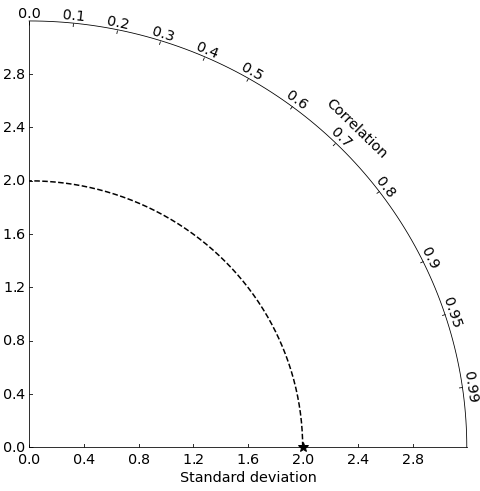

In [47]:
models = {}
models['erad01'] = erad01_slice['ws']

fig = plt.figure(figsize=(8, 8))
td = TaylorDiagram(obs_slice['wind_speed'].std().values, label='lidar', fig=fig,
                   srange=(0, 1.6), extend=False,
                   corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                   #minorcorrticks=np.arange(0.05,0.9,0.1),
                   #stdevticks=np.arange(0.2,2,0.2),
                   labelsize='x-large')

for name, series in models.items():
    corr_xy = np.corrcoef(obs_slice['wind_speed'], series)[0,1]
    R2 = corr_xy**2
    stdev = series.std().values
    print(name, stdev, R2)
    td.add_sample(stdev, R2,
                  marker='o', ms=10, ls='', alpha=0.7,
                  #mfc=color, mec=color,
                  label=name)

#td = TaylorDiagram(erad01_slice['ws'].std().values)

In [14]:
obs_ds['wind_speed'][]

<xarray.DataArray 'wind_speed' (time: 96, height: 164)>
dask.array<getitem, shape=(96, 164), dtype=float32, chunksize=(96, 164), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-08-05T00:00:45.841247 ... 2018-08-05T...
  * height   (height) float32 90.93 116.9 142.9 ... 4.274e+03 4.3e+03 4.326e+03
Attributes:
    long_name:  Wind speed
    units:      m/s

# obs

# wrf

# compare

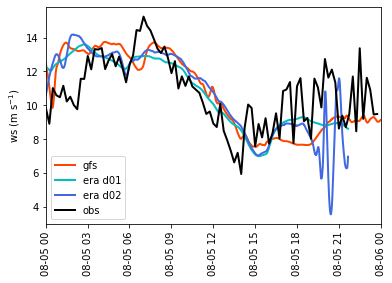

In [53]:
lw = 2
plt.plot(gfs_ds['datetime'], gfs_ds['ws'][:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(erad01_ds['datetime'], erad01_ds['ws'][:, 1], label='era d01', c='c', linewidth=lw)
plt.plot(erad02_ds['datetime'], erad02_ds['ws'][:, 1], label='era d02', c='royalblue', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_speed'][:, 1], label='obs', c='k', linewidth=lw)
plt.xticks(rotation='vertical')
plt.xlim(parser.parse('2018-08-05'), parser.parse('2018-08-06'))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()